# Visualization of HUVEC Nuclei

Version History:  
* v1 -- original dev  
* v2 -- dev with modular code

In [1]:
import importlib
import confocal
importlib.reload(confocal)

import glob, os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import imageio
import re
from scipy.ndimage.morphology import binary_dilation
from scipy.ndimage.measurements import center_of_mass
from scipy.interpolate import interp2d,RegularGridInterpolator
from random import random
from tqdm import tqdm
from scipy.interpolate import interp1d

from itertools import accumulate
from skimage.measure import find_contours
from scipy.spatial import ConvexHull


non-series
item: {'count': [800, 800, 26], 'extent': (0, 799, 0, 799, 1.0, 26.0), 'fxn': <scipy.interpolate.interpolate.RegularGridInterpolator object at 0x7f85b16690d0>}
dims: 3
(101, 1, 1) (1, 101, 1) (1, 1, 20)
0.0
New 3D item has extent: (360, 460, 350, 450, 1, 20) counts: [101, 101, 20]
z was: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.] 26
non-series
item: {'count': [800, 800, 26], 'extent': (0, 799, 0, 799, 1.0, 26.0), 'fxn': <scipy.interpolate.interpolate.RegularGridInterpolator object at 0x7f8590235e90>}
dims: 3
(101, 1, 1) (1, 101, 1) (1, 1, 20)
25.0
New 3D item has extent: (360, 460, 350, 450, 1, 20) counts: [101, 101, 20]
z was: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.] 26
Cell: 1


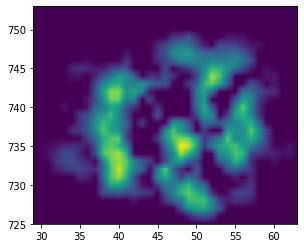

In [2]:
cs1 = confocal.make_default_obj()

In [3]:
def find_envelope3D(self, target, result, n_angle=20, n_r=41, max_r=30):

    x0 = self.getCoM(target)
#     print(x0)
    
    envelope = np.zeros((n_angle,n_angle,3))
    envelope_r = np.zeros((n_angle,n_angle))
    rspace = np.linspace(0,max_r,n_r)
    phi_space = np.linspace(-np.pi/2,np.pi/2,envelope.shape[0])
    theta_space = np.linspace(0,2*np.pi,envelope.shape[1])

    def get_pct(x, pct=0.95):
        x_min = np.repeat(np.expand_dims(np.min(x,0)*pct,0),np.shape(x)[0],0)
        return np.argmin(x_min-x<0,0)

    for i,phi in enumerate(phi_space):

        x0_repeats = np.array([[x0]]).repeat(len(theta_space),1)
        x_nor = np.array([[[np.cos(th0)*np.cos(phi),
            np.sin(th0)*np.cos(phi),
            np.sin(phi)] for th0 in theta_space]])

        r_repeats = np.expand_dims(np.expand_dims(rspace,1),1)
        radial_xy = x0_repeats + x_nor*r_repeats

        indata = self.data[target]['fxn'](radial_xy)

        envelope[i] = np.array([radial_xy[arg,i,:] 
            for arg,i in zip(get_pct(list(accumulate(-indata))), range(len(np.argmin(list(accumulate(-indata)),0))))])

#         print(envelope[i])

    self.data[result] = envelope
    


#     data = self.data[target]

#     envelope = np.zeros((n_angle, n_angle, 3))
#     envelope_r = np.zeros((n_angle, n_angle))

#     rspace = np.linspace(0, max_r, n_r)

#     phi_space = np.linspace(0, 2 * np.pi, envelope.shape[0])
#     theta_space = np.linspace(0, 2 * np.pi, envelope.shape[1])

#     for i in tqdm(range(envelope.shape[0])):
#         for j in range(envelope.shape[1]):
#             phi = phi_space[i]
#             th0 = theta_space[j]

#             radial_xy = np.array([(
#                 x0[0] + r * np.cos(th0) * np.cos(phi),
#                 x0[1] + r * np.sin(th0) * np.cos(phi),
#                 x0[2] + r * np.sin(phi),
#             ) for r in rspace])
#             #         print(radial_xy[0])
#             indata = np.array([data['fxn'](_)[0] for _ in radial_xy])
#             plt.plot(rspace, list(accumulate(-indata)))
#             #         print('res:',radial_xy[np.argmin(list(accumulate(-indata)))])
#             envelope[i, j] = (radial_xy[np.argmin(list(accumulate(-indata)))])

#     foo['envelope'] = envelope
#     foo['envelope_r'] = envelope_r
#     foo['envelope_th'] = theta_space
#     foo['envelope_ph'] = phi_space



In [4]:
cs1.find_envelope3D('blue_cropped3D', 'blue_cropped_env', n_angle=80)

slices at: x=410.0, y=400.0, z=10.0
showing extent: (360, 460, 350, 450, 1, 20)
extent: (360, 460, 350, 450, 1, 20) (410.0, 400.0, 10)
shape: (671, 2) sliceyz: 410.0


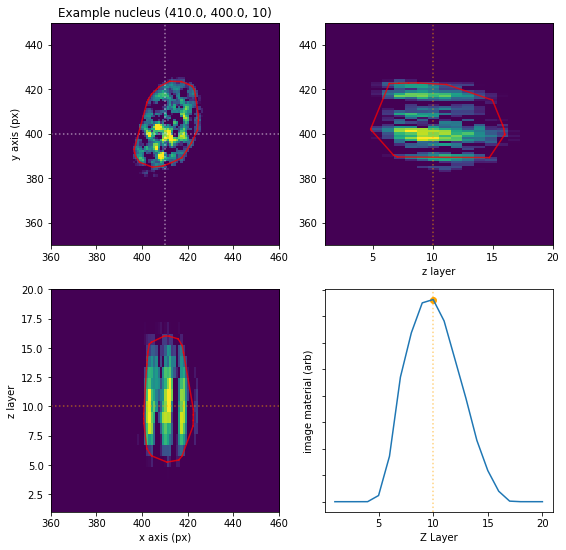

In [5]:
cs1.four_panel('blue_cropped3D', debug=True, upscale=1, desc='Example nucleus', 
               z=10, thickness=0.5,  envelopes=['blue_cropped_env',],) # do_save='middle_L10_noenv.png',)

In [6]:
def find_envelope2D(self, target, result, sliced, n_angle=40, n_r=41, max_r=30, pct=0.95):

    x0 = self.getCoM(target)

    envelope = np.zeros((n_angle, n_angle, 2))

    rspace = np.linspace(0, max_r, n_r)
    theta_space = np.linspace(0, 2 * np.pi, envelope.shape[1])

    def get_pct(x, pct=pct):
        x_min = np.repeat(np.expand_dims(np.min(x, 0) * pct, 0), np.shape(x)[0], 0)
        return np.argmin(x_min - x < 0, 0)

    x0_repeats = np.array([[x0]]).repeat(len(theta_space), 1)
    x_nor = np.array([[[np.cos(th0),
                        np.sin(th0)] for th0 in theta_space]])

    r_repeats = np.expand_dims(rspace, 1)
    radial_xy = x0_repeats + x_nor * r_repeats

    indata = self.data[target]['fxn'](radial_xy)

    envelope = np.array([radial_xy[arg, i, :]
                            for arg, i in zip(get_pct(list(accumulate(-indata))),
                                              range(len(np.argmin(list(accumulate(-indata)), 0))))])


    self.data[result] = envelope

In [7]:
# the point of this 

res =cs1.create_cropped('cyto_linear_mask2D', cropped_name='green_test2', series=True,
                         window=(310, 510, 300, 500, 1, 20), debug=True)

# cs1.render_image('green_test',sliced=10)
# cs1.four_panel('green_test',z=10)
# cs1.data['green_test'].keys()
# print('hello')

series
item: {'count': [96, 125], 'extent': [0, 95, 654, 778], 'fxn': <scipy.interpolate.interpolate.RegularGridInterpolator object at 0x7f8590235450>}
dims: 2
New item has extent: (310, 510, 300, 500, 1, 20)
item: {'count': [153, 151], 'extent': [0, 152, 0, 150], 'fxn': <scipy.interpolate.interpolate.RegularGridInterpolator object at 0x7f8590235490>}
dims: 2
New item has extent: (310, 510, 300, 500, 1, 20)
item: {'count': [137, 377], 'extent': [0, 136, 277, 653], 'fxn': <scipy.interpolate.interpolate.RegularGridInterpolator object at 0x7f85902354d0>}
dims: 2
New item has extent: (310, 510, 300, 500, 1, 20)
item: {'count': [118, 261], 'extent': [27, 144, 535, 795], 'fxn': <scipy.interpolate.interpolate.RegularGridInterpolator object at 0x7f8590235510>}
dims: 2
New item has extent: (310, 510, 300, 500, 1, 20)
item: {'count': [103, 150], 'extent': [58, 160, 78, 227], 'fxn': <scipy.interpolate.interpolate.RegularGridInterpolator object at 0x7f8590235550>}
dims: 2
New item has extent: (310

In [8]:
'HUVEC 3D Reconstruction Files/HUVEC Tubulin AD 0.7 ZStack Decon cellSens.export/objects/'

'HUVEC 3D Reconstruction Files/HUVEC Tubulin AD 0.7 ZStack Decon cellSens.export/objects/'

In [9]:
def find_envelope_cyl(self, target, result, n_angle=30, n_r=41, max_r=30, pct=0.95, upscale=1):
    
    x0 = self.getCoM(target)
    
    data = self.data[target]
    pz = np.expand_dims(np.linspace(data['extent'][4], data['extent'][5], data['count'][2] * upscale), 1)
#     print('pz', pz)

    def radial_env(z,d):
#         print('received d', d.keys(), z)

        rspace = np.linspace(0, max_r, n_r)
        theta_space = np.linspace(0, 2 * np.pi, n_angle)

        def get_pct(x, pct=pct):
            x_min = np.repeat(np.expand_dims(np.min(x, 0) * pct, 0), np.shape(x)[0], 0)
            return np.argmin(x_min - x < 0, 0)

        
        x0_repeats = np.array([[[x0[0], x0[1], z]]]).repeat(n_angle, 1)
        x_nor = np.array([[[np.cos(th0),
                            np.sin(th0), 0] for th0 in theta_space]])

        r_repeats = np.expand_dims(np.expand_dims(rspace, 1),1)
        
#         print('shapes:', x0_repeats.shape, x_nor.shape, r_repeats.shape)
        radial_xy = x0_repeats + x_nor * r_repeats

        indata = self.data[target]['fxn'](radial_xy)

        envelope = np.array([radial_xy[arg, i, :]
                                for arg, i in zip(get_pct(list(accumulate(-indata))),
                                                  range(len(np.argmin(list(accumulate(-indata)), 0))))])

        return envelope
    
    # can't just pass rendered slices -- need a function so we can interpolate rays
    # envelop_cyl = [radial_env(z,self.render_image(target, sliced=z, style='XY', upscale=upscale, do_plot=False)) for z in pz]

    envelope_cyl = np.array([radial_env(z,data) for z in pz])
#     envelope_cyl = radial_env(10, data)  
        
        
    self.data[result] = envelope_cyl
    
    return envelope_cyl
    
test_env = find_envelope_cyl(cs1, 'green_cropped3D', 'green_cropped_env_cyl', n_angle=40, n_r=41, max_r=300, pct=0.95)

In [10]:
def create_cropped(self, target, series=True, cropped_name=None, x0=None, window=None, debug=False, mask=None):

    if window is None:
        pass
    
    def do_crop(item):
        print('item:', item)
        dims = len(item['extent']) // 2
        print('dims:', dims)

        if dims == 2:
            x = np.linspace(item['extent'][0], item['extent'][1], item['count'][0])
            y = np.linspace(item['extent'][2], item['extent'][3], item['count'][1])

            x = x[(x >= window[0]) & (x <= window[1])]
            y = y[(y >= window[2]) & (y <= window[3])]

            xx, yy = np.expand_dims(x, 0), np.expand_dims(y, 0)

            data = item['fxn']((xx, yy))
            if debug: print('New item has extent:', window)

            return {
                'count': [len(x), len(y)],
                'extent': window,
                'fxn': RegularGridInterpolator((x, y), data, bounds_error=False, fill_value=0, method='linear')
            }

        elif dims == 3:
            x = np.linspace(item['extent'][0], item['extent'][1], item['count'][0])
            y = np.linspace(item['extent'][2], item['extent'][3], item['count'][1])
            z = np.linspace(item['extent'][4], item['extent'][5], item['count'][2])

            x = x[(x >= window[0]) & (x <= window[1])]
            y = y[(y >= window[2]) & (y <= window[3])]
            if len(window) > 4: z = z[(z >= window[4]) & (z <= window[5])]

            xx, yy, zz = np.reshape(x, [-1, 1, 1]), np.reshape(y, [1, -1, 1]), np.reshape(z, [1, 1, -1])
            data = item['fxn']((xx, yy, zz))

            if debug:
                print(xx.shape, yy.shape, zz.shape)
                print(item['fxn']((x[0], y[0], z[0])))
                print('New 3D item has extent:', window, 'counts:', [len(x), len(y), len(z)], )
                print('z was:', z, item['count'][2])

            return {
                'count': [len(x), len(y), len(z)],
                'extent': window,
                'fxn': RegularGridInterpolator((x, y, z), data, bounds_error=False, fill_value=0, method='linear')
            }

        else:
            raise Exception('wrong number of dims in cropped data', dims == 2, dims == 3, dims)

    if mask is not None:
        mask_fxn = lambda x,y: 1

    
    data = self.data[target]
    print('data keys:', data.keys())

    if series:
        print('series')
        self.data[cropped_name] = {idx: do_crop(data[idx]) for idx in data}
    else:
        print('non-series')
        self.data[cropped_name] = do_crop(data)

In [11]:
# create_cropped(cs1, 'green_linear3D', cropped_name='test_crop', series=False, debug=True, mask=cs1.data['cyto_linear_mask2D'][1])



In [12]:
# cs1.four_panel('test_crop',z=10)

In [13]:
# cs1.render_image('cyto_linear_mask2D',do_plot=True, sliced=30)
# cs1.data['cyto_linear_mask2D'][1]

(20, 40, 3)


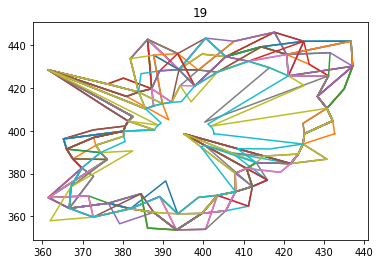

In [14]:
print(test_env.shape)
# print(test_env)
# plt.plot(test_env[0].T[0], test_env[0].T[1])

for n,t in enumerate(test_env):
    plt.plot(t.T[0], t.T[1])
    plt.title(n);
#     plt.show()
    

slices at: x=410.0, y=400.0, z=9.0
showing extent: (360, 460, 350, 450, 1, 20)
extent: (360, 460, 350, 450, 1, 20) (410.0, 400.0, 10)
shape: (322, 2) sliceyz: 410.0


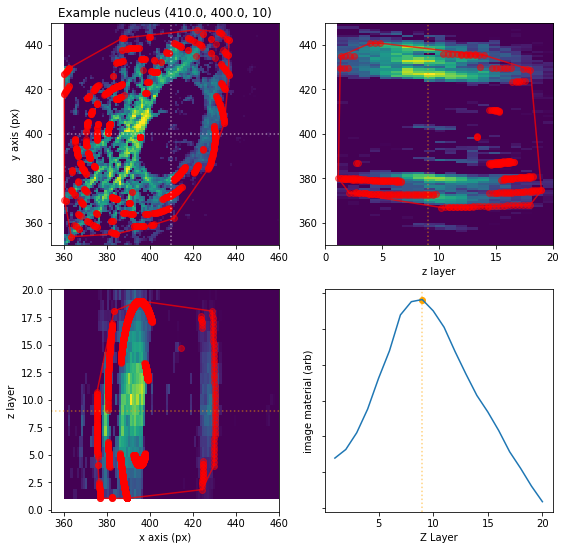

In [15]:
######## Trying to fit a 3D envelope to cytoplasm, it's easier to see where it goes wrong

# res = cs1.render_image('green_cropped3D', sliced=20, do_plot=True)
cs1.find_envelope3D('green_cropped3D', 'green_cropped_env', n_angle=320, max_r=200, pct=0.93)
cs1.four_panel('green_cropped3D', debug=True, upscale=1, desc='Example nucleus', scatter_too=True,
               z=9, thickness=0.5,  envelopes=['green_cropped_env',]) # do_save='middle_L10_noenv.png',)
# find_envelope2D(cs1,'green_cropped2D',sliced=10)

In [16]:
foo = cs1.make_interp2D('cyto_mask', 'cyto_linear_mask2D', color=None, shrink=True, debug=False)  # unused
cs1.data['cyto_linear_mask2D']
# print(foo)

{1: {'count': [96, 125],
  'extent': [0, 95, 654, 778],
  'fxn': <scipy.interpolate.interpolate.RegularGridInterpolator at 0x7f8590df7b50>},
 2: {'count': [153, 151],
  'extent': [0, 152, 0, 150],
  'fxn': <scipy.interpolate.interpolate.RegularGridInterpolator at 0x7f85b34068d0>},
 3: {'count': [137, 377],
  'extent': [0, 136, 277, 653],
  'fxn': <scipy.interpolate.interpolate.RegularGridInterpolator at 0x7f85b3406110>},
 4: {'count': [118, 261],
  'extent': [27, 144, 535, 795],
  'fxn': <scipy.interpolate.interpolate.RegularGridInterpolator at 0x7f85b3406d50>},
 5: {'count': [103, 150],
  'extent': [58, 160, 78, 227],
  'fxn': <scipy.interpolate.interpolate.RegularGridInterpolator at 0x7f85b3406190>},
 6: {'count': [138, 213],
  'extent': [113, 250, 317, 529],
  'fxn': <scipy.interpolate.interpolate.RegularGridInterpolator at 0x7f85b34066d0>},
 7: {'count': [115, 204],
  'extent': [130, 244, 62, 265],
  'fxn': <scipy.interpolate.interpolate.RegularGridInterpolator at 0x7f85b34064d0>},

{'count': [96, 125], 'extent': [0, 95, 654, 778], 'fxn': <scipy.interpolate.interpolate.RegularGridInterpolator object at 0x7f8590df7b50>}


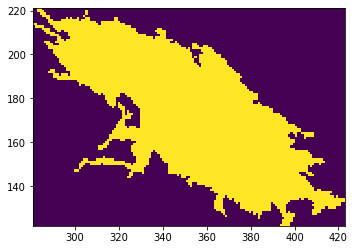

In [17]:
print(cs1.data['cyto_linear_mask2D'][1])
res = cs1.render_image(data=cs1.data['cyto_linear_mask2D'][20], do_plot=True)
plt.show()
# res = cs1.render_image('cyto_linear_mask2D', do_plot=True, sliced=20, series=True)
# plt.show()
# res = cs1.render_image('')

In [18]:
cyto_id = 2
# res = cs1.render_image('cyto_linear_mask2D', do_plot=True, sliced=10, series=True)
# cs1.four_panel('green_test')
cs1.create_cropped('green_linear3D', cropped_name='green_test', debug=True, series=False, mask=cs1.data['cyto_linear_mask2D'][cyto_id])
cs1.create_cropped('blue_linear3D', cropped_name='blue_test', debug=True, series=False, mask=cs1.data['nucleus_linear_mask2D'][cyto_id])
cs1.find_envelope3D('green_test', 'green_cropped_env', n_angle=320, max_r=200, pct=0.95)
cs1.find_envelope3D('blue_test', 'blue_cropped_env', n_angle=320, max_r=200, pct=0.95)



# cs1.data['green_test']
# cs1.data['green_linear3D']

# cs1.render_image('cyto_linear_mask2D', sliced=cyto_id, series=True, do_plot=True)
# plt.show()
# cs1.render_image('green_test', sliced=10, series=False, do_plot=True)
# plt.show()
# cs1.data['green_test']

# cs1.data['green_test'][20]

non-series
item: {'count': [800, 800, 26], 'extent': (0, 799, 0, 799, 1.0, 26.0), 'fxn': <scipy.interpolate.interpolate.RegularGridInterpolator object at 0x7f8590235e90>}
dims: 3
Using mask extent as default window
(153, 1, 1) (1, 151, 1) (1, 1, 26)
0.0
New 3D item has extent: [0, 152, 0, 150, 1.0, 26.0] counts: [153, 151, 26]
z was: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26.] 26
non-series
item: {'count': [800, 800, 26], 'extent': (0, 799, 0, 799, 1.0, 26.0), 'fxn': <scipy.interpolate.interpolate.RegularGridInterpolator object at 0x7f85b16690d0>}
dims: 3
Using mask extent as default window
(38, 1, 1) (1, 35, 1) (1, 1, 26)
0.0
New 3D item has extent: [39, 76, 33, 67, 1.0, 26.0] counts: [38, 35, 26]
z was: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26.] 26


Cell: 1
Cannot do XZ contour for env 1


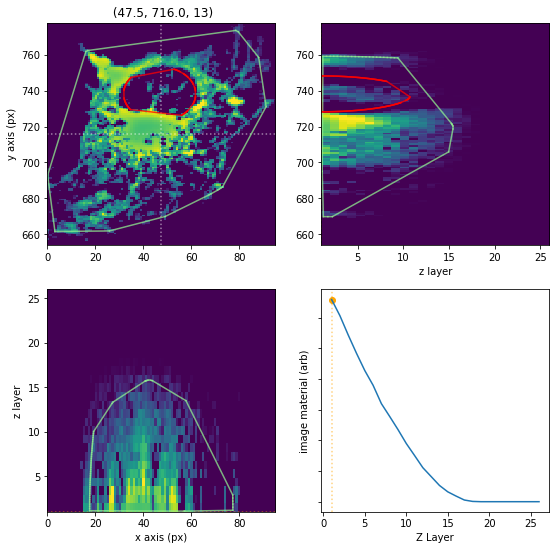

In [19]:
for cyto_id in sorted(cs1.data['cyto_linear_mask2D'].keys()):

    print('Cell:', cyto_id)
    cs1.create_cropped('green_linear3D', cropped_name='green_test_%02d' % cyto_id, debug=False, series=False, mask=cs1.data['cyto_linear_mask2D'][cyto_id])
    cs1.create_cropped('blue_linear3D', cropped_name='blue_test_%02d' % cyto_id, debug=False, series=False, mask=cs1.data['nucleus_linear_mask2D'][cyto_id])
    cs1.find_envelope3D('green_test_%02d' % cyto_id, 'green_cropped_env_%02d' % cyto_id, n_angle=320, max_r=200, pct=0.95)
    cs1.find_envelope3D('blue_test_%02d' % cyto_id, 'blue_cropped_env_%02d' % cyto_id, n_angle=320, max_r=200, pct=0.95)

    cs1.four_panel('green_test_%02d' % cyto_id, envelopes=[{'target':'green_cropped_env_%02d' % cyto_id,'color':'lightgreen'},'blue_cropped_env_%02d' % cyto_id])
    plt.show()
    break

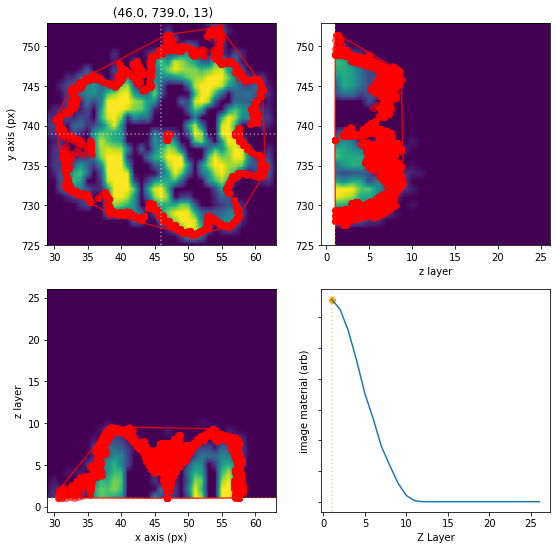

In [20]:
# res = cs1.render_image('blue_test_01', sliced=5, do_plot=True, upscale=10)
cyto_id=1
cs1.find_envelope3D('blue_test_%02d' % cyto_id, 'blue_cropped_env_%02d' % cyto_id, n_angle=320, max_r=60,n_r=101, pct=0.95)

cs1.four_panel('blue_test_01', upscale=10, envelopes=['blue_cropped_env_01'], scatter_too=True)

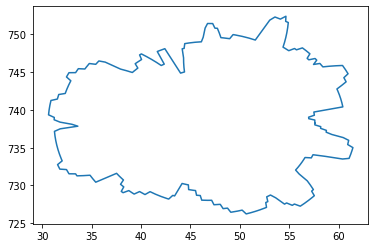

In [21]:
cs1.data['blue_cropped_env_01'][160,:,0].shape
plt.plot(cs1.data['blue_cropped_env_01'][160,:,0],cs1.data['blue_cropped_env_01'][160,:,1])


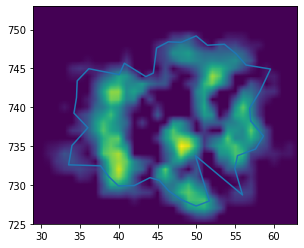

In [27]:
res = cs1.render_image('blue_test_01', sliced=5, do_plot=True, upscale=10)
env01 = cs1.find_radial_envelope('blue_test_01', pct=0.85)
plt.plot(env01.T[0],env01.T[1])

{'count': [153, 151, 26], 'extent': [0, 152, 0, 150, 1.0, 26.0], 'fxn': <scipy.interpolate.interpolate.RegularGridInterpolator object at 0x7f8590df1810>}
(153, 151)


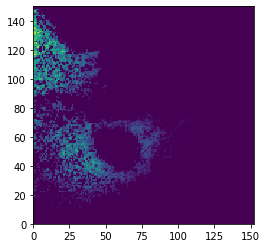

In [23]:
print(cs1.data['green_test'])
data = cs1.data['green_test']
upscale=1
px = np.expand_dims(np.linspace(data['extent'][0], data['extent'][1], data['count'][0] * upscale), 0)
py = np.expand_dims(np.linspace(data['extent'][2], data['extent'][3], data['count'][1] * upscale), 1)

cs1.data['green_test']['extent']
res = cs1.render_image('green_test', series=False, sliced=10, do_plot=True)
print(res.shape)

In [24]:
if False:
    level = 13
    thickness=1
    applies = abs(env[:,:,2]-level)<thickness
    print(np.sum(applies))
    res = env[applies]

    #         print(res)
    #         plt.plot(res.T[1], res.T[0], color='red')

    hull = ConvexHull(res[:,0:2])
    for simplex in hull.simplices:
        print(simplex)
        plt.plot(res[simplex, 1], res[simplex, 0], color='red')


In [25]:
# cs1.four_panel('blue_linear3D', z=10)

In [29]:
import pyefd

ModuleNotFoundError: No module named 'pyefd'

In [33]:
import sys

print(sys.executable)

/Users/asears/opt/anaconda3/bin/python


In [40]:
from pyefd import elliptic_fourier_descriptors, plot_efd, reconstruct_contour

In [39]:
cnt = elliptic_fourier_descriptors(env01, order=2)


array([[11.27901461, -2.12492197,  1.68967512,  9.46346533],
       [-0.84033812,  1.59545642, -0.88635532,  0.54599899]])

In [35]:
import cv2